### **Comparative Analysis of Random Forest and SVC Models**

In this notebook, we will load two pre-trained classification models—a Random Forest and a Support Vector Classifier (SVC)—and compare their performance on the same test dataset. Both models were trained to classify jokes into categories based on their embeddings.

We will perform a detailed comparison by evaluating various performance metrics, analyzing confusion matrices, and discussing the strengths and weaknesses of each model. By iterating through different aspects of the comparison, we aim to gain a comprehensive understanding of how each model performs and under what circumstances one might outperform the other.

### **Table of Contents**

1. [Import Statements](#import)
2. [Load Data and Models](#load)
3. [Data Preprocessing](#preprocess)
4. [Model Predictions](#predict)
5. [Performance Evaluation](#evaluate)
6. [Comparative Analysis](#compare)
7. [Error Analysis](#error)
8. [Conclusion](#conclude)

<a id='import'></a>
### **1. Import Statements**

In [1]:
import pandas as pd
import numpy as np
import os
import joblib
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (confusion_matrix, classification_report, accuracy_score,
                             precision_score, recall_score, f1_score)

<a id='load'></a>
### **2. Load Data and Models**

In [2]:
# Load the processed data
final_joke_dataset = r'..\..\data\processed\output_final_joke_dataset_expanded.json'

# Load data in chunks to prevent memory overload
chunk_size = 5000
df_chunks = []

with tqdm(total=84824, desc="Loading JSON data") as pbar:
    for chunk in pd.read_json(final_joke_dataset, lines=True, chunksize=chunk_size):
        df_chunks.append(chunk)
        pbar.update(len(chunk))

# Concatenate the chunks into a single DataFrame
df = pd.concat(df_chunks, ignore_index=True)

print("Data loaded successfully.")

# Encode the categories to numerical labels
label_encoder = LabelEncoder()
df['category_encoded'] = label_encoder.fit_transform(df['category'])

# Save the label encoder for future use
label_encoder_path = os.path.join('models', 'label_encoder.joblib')
joblib.dump(label_encoder, label_encoder_path)
print(f"Label encoder saved to {label_encoder_path}")

# Features and labels
X = df.drop(columns=['category', 'category_encoded'])
y = df['category_encoded']

# Drop rows with missing values
data = df.dropna()

X = data.drop(columns=['category', 'category_encoded'])
y = data['category_encoded']

# Split the data into training and test sets
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42, stratify=y
)

print(f"Training data shape: {X_train_full.shape}")
print(f"Test data shape: {X_test.shape}")

# Load the models
model_dir = 'models'

# Random Forest Models
base_rf_model_path = os.path.join(model_dir, 'base_rf_classifier.joblib')
hypertuned_rf_model_path = os.path.join(model_dir, 'hypertuned_rf_classifier.joblib')

base_rf_classifier = joblib.load(base_rf_model_path)
hypertuned_rf_classifier = joblib.load(hypertuned_rf_model_path)

print("Random Forest models loaded successfully.")

# SVC Models
base_svc_model_path = os.path.join(model_dir, 'base_svc_classifier.joblib')
hypertuned_svc_model_path = os.path.join(model_dir, 'hypertuned_svc_classifier.joblib')
scaler_path = os.path.join(model_dir, 'scaler.joblib')

base_svc_classifier = joblib.load(base_svc_model_path)
hypertuned_svc_classifier = joblib.load(hypertuned_svc_model_path)
scaler = joblib.load(scaler_path)

print("SVC models and scaler loaded successfully.")


Loading JSON data: 100%|█████████▉| 84818/84824 [01:16<00:00, 1109.84it/s]


Data loaded successfully.
Label encoder saved to models\label_encoder.joblib
Training data shape: (76336, 1536)
Test data shape: (8482, 1536)
Random Forest models loaded successfully.
SVC models and scaler loaded successfully.


<a id='preprocess'></a>
### **3. Data Preprocessing**

In [3]:
# For SVC models, we need to scale the features
# Use the scaler that was fitted during training

X_test_scaled = scaler.transform(X_test)

# For Random Forest models, we can use the features as they are
X_test_rf = X_test.copy()

<a id='predict'></a>
### **4. Model Predictions**

In [4]:
# Random Forest Models
y_pred_base_rf = base_rf_classifier.predict(X_test_rf)
y_pred_hypertuned_rf = hypertuned_rf_classifier.predict(X_test_rf)

# SVC Models
y_pred_base_svc = base_svc_classifier.predict(X_test_scaled)
y_pred_hypertuned_svc = hypertuned_svc_classifier.predict(X_test_scaled)

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 150 out of 150 | elapsed:    0.1s finished


<a id='evaluate'></a>
### **5. Performance Evaluation**

In [5]:
# Define a function to compute evaluation metrics
def compute_metrics(y_true, y_pred, model_name):
    accuracy = accuracy_score(y_true, y_pred)
    precision_macro = precision_score(y_true, y_pred, average='macro', zero_division=0)
    recall_macro = recall_score(y_true, y_pred, average='macro', zero_division=0)
    f1_macro = f1_score(y_true, y_pred, average='macro', zero_division=0)
    
    print(f"\nModel: {model_name}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Macro Precision: {precision_macro:.4f}")
    print(f"Macro Recall: {recall_macro:.4f}")
    print(f"Macro F1 Score: {f1_macro:.4f}")
    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))
    
    return {
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision (Macro)': precision_macro,
        'Recall (Macro)': recall_macro,
        'F1 Score (Macro)': f1_macro
    }

# Evaluate models
results = []

# Base Random Forest
metrics_base_rf = compute_metrics(y_test, y_pred_base_rf, 'Base Random Forest')
results.append(metrics_base_rf)

# Hypertuned Random Forest
metrics_hypertuned_rf = compute_metrics(y_test, y_pred_hypertuned_rf, 'Hypertuned Random Forest')
results.append(metrics_hypertuned_rf)

# Base SVC
metrics_base_svc = compute_metrics(y_test, y_pred_base_svc, 'Base SVC')
results.append(metrics_base_svc)

# Hypertuned SVC
metrics_hypertuned_svc = compute_metrics(y_test, y_pred_hypertuned_svc, 'Hypertuned SVC')
results.append(metrics_hypertuned_svc)

# Create a DataFrame to display the results
results_df = pd.DataFrame(results)


Model: Base Random Forest
Accuracy: 0.6175
Macro Precision: 0.8135
Macro Recall: 0.4391
Macro F1 Score: 0.5360
Classification Report:
                          precision    recall  f1-score   support

                  Animal       0.84      0.47      0.60       344
                  Blonde       0.93      0.72      0.81       154
               Celebrity       0.91      0.25      0.39       124
                     Dad       0.74      0.39      0.51       193
              Dark Humor       0.53      0.77      0.63      1580
           Doctor/Health       0.90      0.58      0.71       256
                  Ethnic       0.90      0.52      0.66       567
                    Food       0.96      0.30      0.45        81
                  In-Law       1.00      0.18      0.30        17
                  Insult       0.83      0.21      0.34        47
                    Kids       0.61      0.25      0.35       122
             Knock-Knock       1.00      0.40      0.57        15
      

In [6]:
# Display the results
print("\nSummary of Model Performance:")
results_df = results_df.set_index('Model')
display(results_df)


Summary of Model Performance:


,Accuracy,Precision (Macro),Recall (Macro),F1 Score (Macro)
Model,,,,
Base Random Forest,0.617543,0.813512,0.439098,0.536046
Hypertuned Random Forest,0.660340,0.768826,0.548157,0.613264
Base SVC,0.562957,0.511954,0.756022,0.571570
Hypertuned SVC,0.562957,0.511954,0.756022,0.571570


<a id='compare'></a>
### **6. Comparative Analysis**

#### **Confusion Matrices**

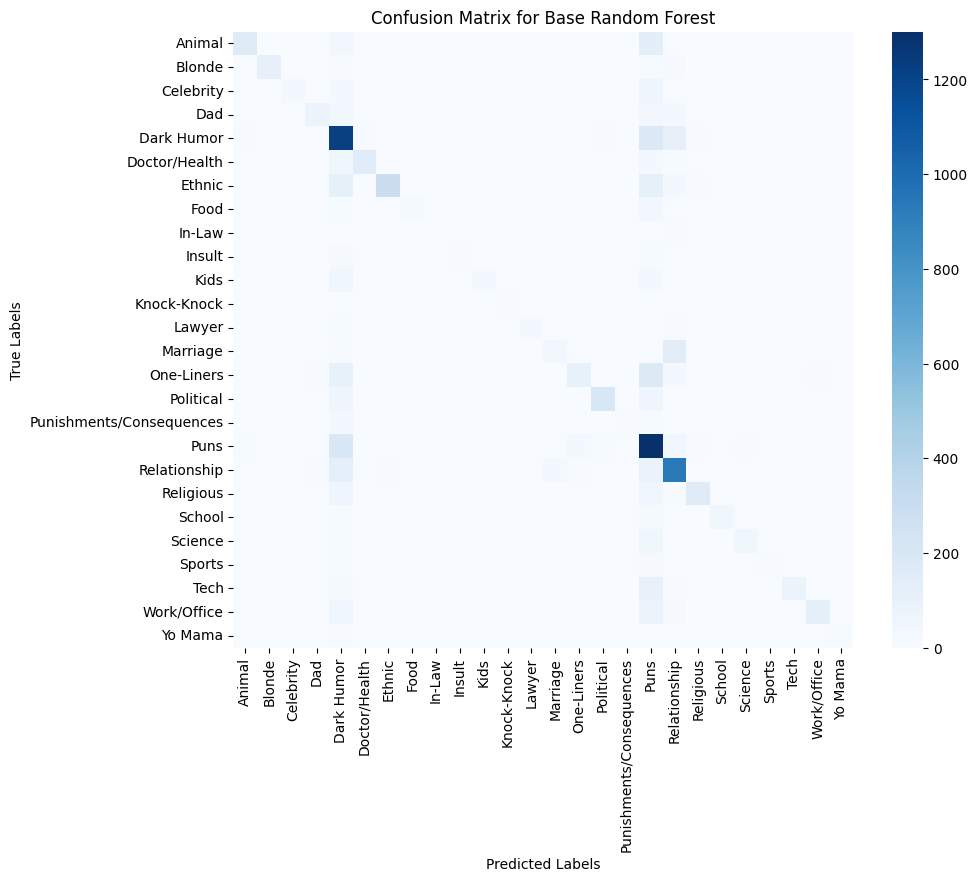

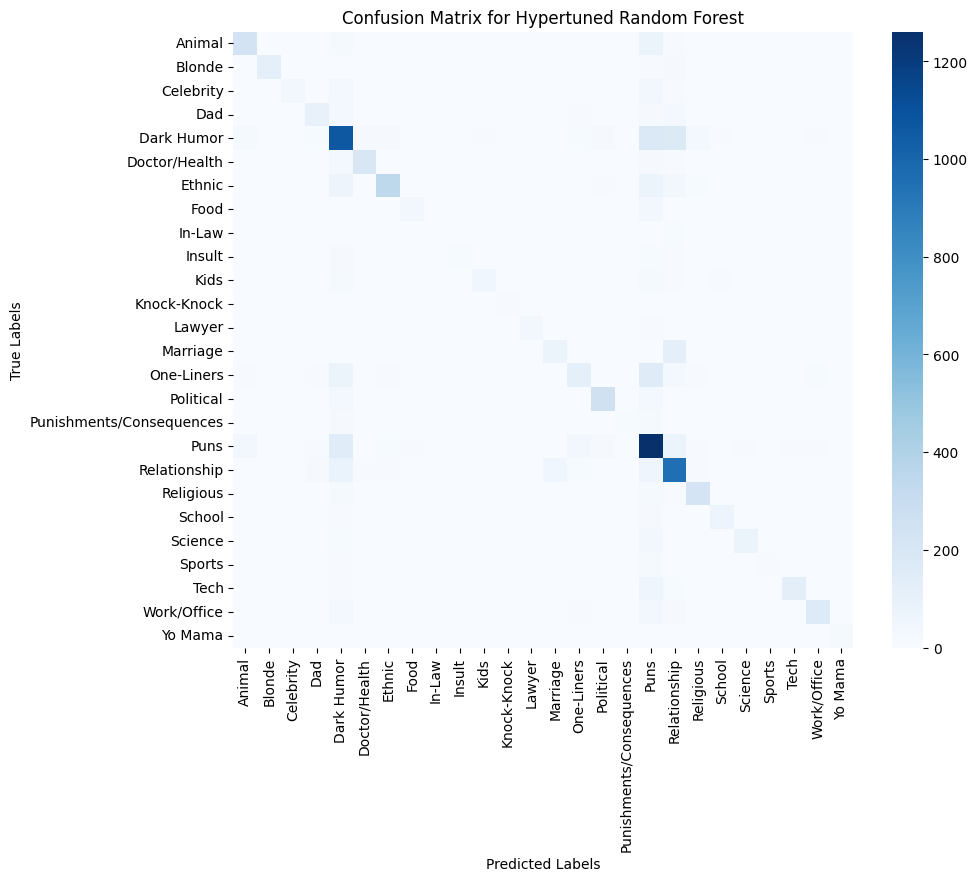

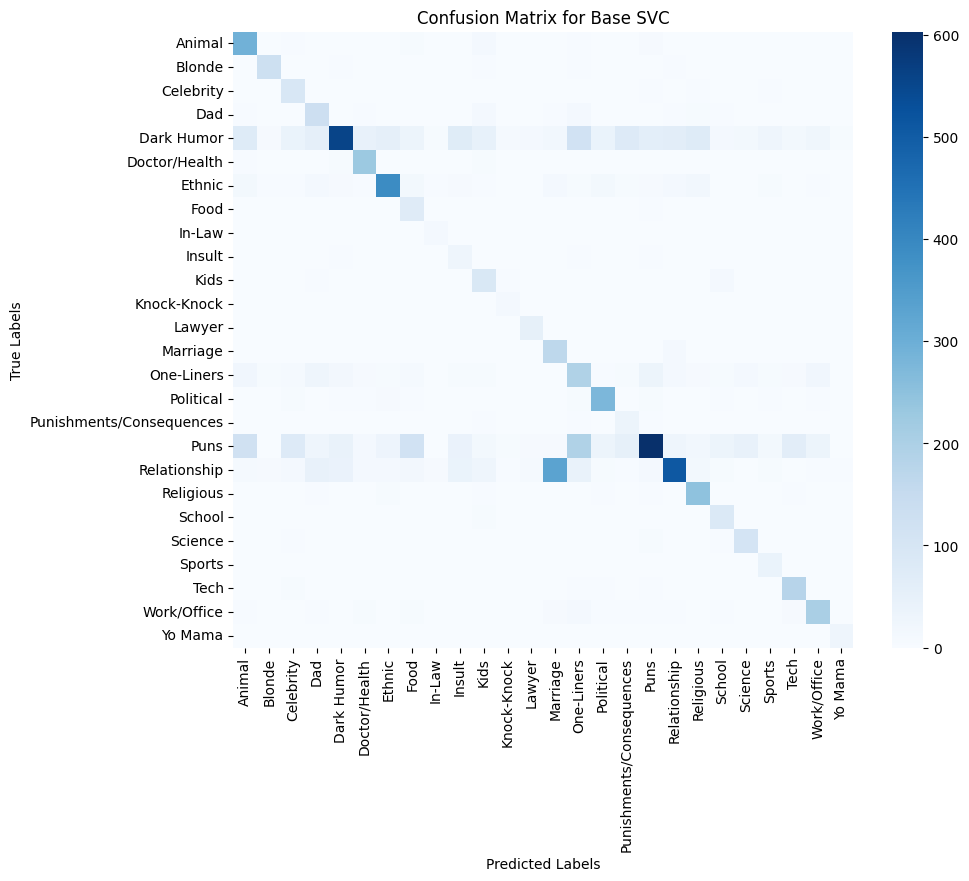

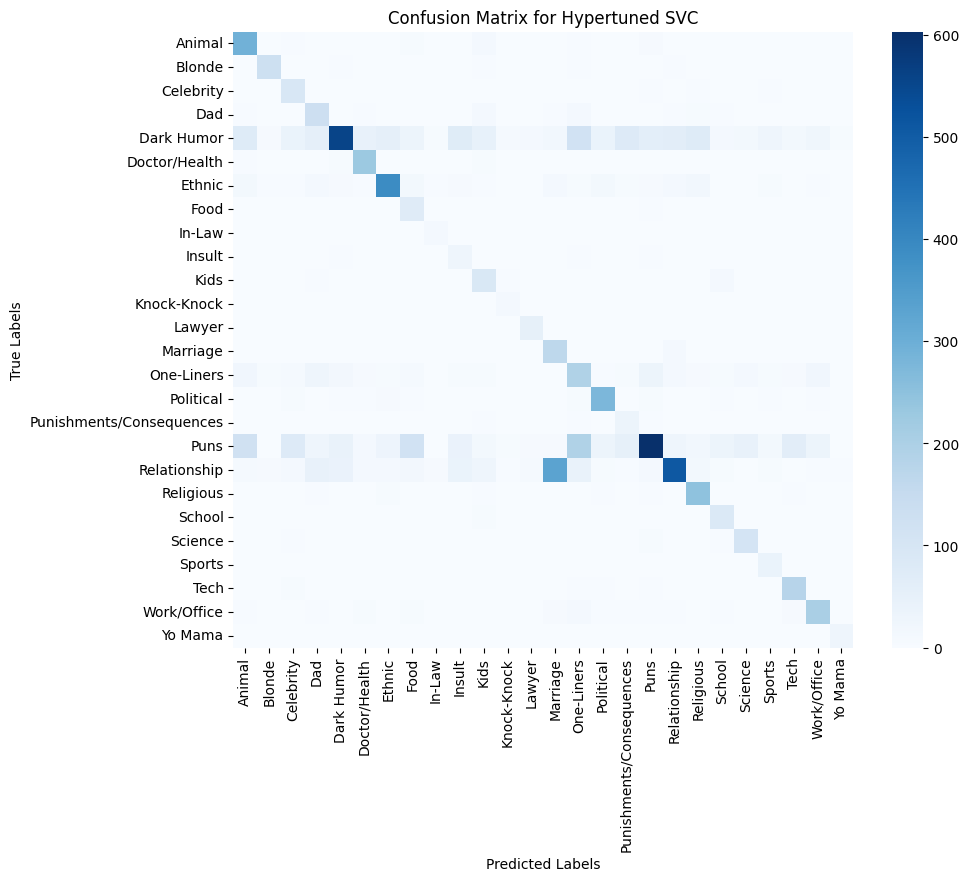

In [7]:
# Define a function to plot confusion matrices
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=False, fmt='d', cmap='Blues',
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_)
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

# Plot confusion matrices
plot_confusion_matrix(y_test, y_pred_base_rf, 'Base Random Forest')
plot_confusion_matrix(y_test, y_pred_hypertuned_rf, 'Hypertuned Random Forest')
plot_confusion_matrix(y_test, y_pred_base_svc, 'Base SVC')
plot_confusion_matrix(y_test, y_pred_hypertuned_svc, 'Hypertuned SVC')


#### **Per-Class Performance**


In [8]:
# Extract per-class metrics from classification reports

def get_classification_report_dict(y_true, y_pred):
    report_dict = classification_report(y_true, y_pred, target_names=label_encoder.classes_, output_dict=True, zero_division=0)
    df = pd.DataFrame(report_dict).transpose()
    df = df.iloc[:-3]  # Exclude 'accuracy', 'macro avg', 'weighted avg'
    return df

# Get per-class metrics for each model
report_base_rf = get_classification_report_dict(y_test, y_pred_base_rf)
report_hypertuned_rf = get_classification_report_dict(y_test, y_pred_hypertuned_rf)
report_base_svc = get_classification_report_dict(y_test, y_pred_base_svc)
report_hypertuned_svc = get_classification_report_dict(y_test, y_pred_hypertuned_svc)

# Add model identifiers
report_base_rf['Model'] = 'Base Random Forest'
report_hypertuned_rf['Model'] = 'Hypertuned Random Forest'
report_base_svc['Model'] = 'Base SVC'
report_hypertuned_svc['Model'] = 'Hypertuned SVC'

# Combine reports
per_class_metrics = pd.concat([report_base_rf, report_hypertuned_rf, report_base_svc, report_hypertuned_svc], axis=0)

# Reset index to have 'category' as a column
per_class_metrics = per_class_metrics.reset_index().rename(columns={'index': 'Category'})

# Rearrange columns
per_class_metrics = per_class_metrics[['Model', 'Category', 'precision', 'recall', 'f1-score', 'support']]

# Display per-class metrics
per_class_metrics.head()

,Model,Category,precision,recall,f1-score,support
0,Base Random Forest,Animal,0.835897,0.473837,0.604824,344.0
1,Base Random Forest,Blonde,0.925000,0.720779,0.810219,154.0
2,Base Random Forest,Celebrity,0.911765,0.250000,0.392405,124.0
3,Base Random Forest,Dad,0.742574,0.388601,0.510204,193.0
4,Base Random Forest,Dark Humor,0.532955,0.772785,0.630845,1580.0


#### **Per-Class F1-Scores Visualization**

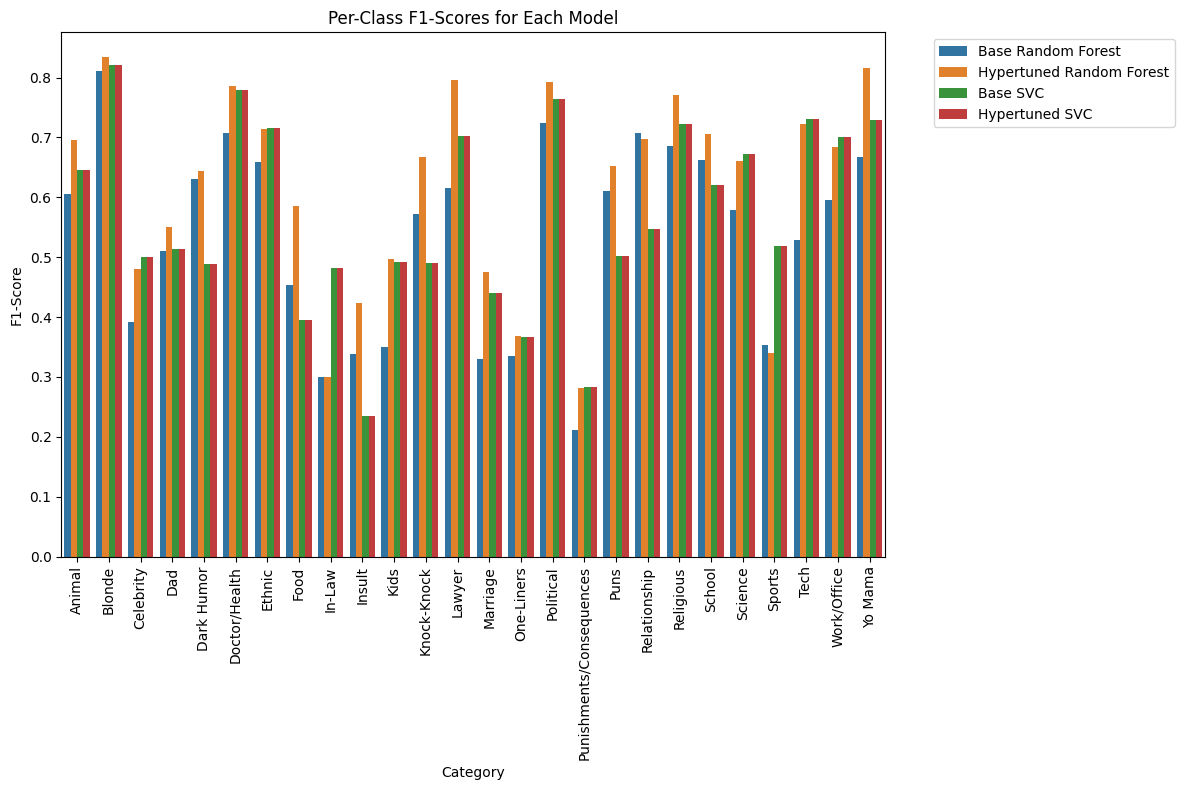

In [9]:
# Plot per-class F1-scores for each model

plt.figure(figsize=(12, 8))
sns.barplot(data=per_class_metrics, x='Category', y='f1-score', hue='Model')
plt.xticks(rotation=90)
plt.title('Per-Class F1-Scores for Each Model')
plt.ylabel('F1-Score')
plt.xlabel('Category')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

<a id='error'></a>
### **7. Error Analysis**
#### **Instances Where Models Disagree**


In [10]:
# Identify instances where the hypertuned models disagree
disagreement_indices = np.where(y_pred_hypertuned_rf != y_pred_hypertuned_svc)[0]

print(f"Number of instances where Hypertuned Random Forest and Hypertuned SVC disagree: {len(disagreement_indices)}")

# Create a DataFrame with the instances where models disagree
disagreement_df = X_test.iloc[disagreement_indices].copy()

# Map the true labels using list comprehension
disagreement_df['True_Label'] = [label_encoder.classes_[x] for x in y_test.iloc[disagreement_indices]]

# Map the predicted labels using list comprehension
disagreement_df['Hypertuned_RF_Pred'] = [label_encoder.classes_[x] for x in y_pred_hypertuned_rf[disagreement_indices]]
disagreement_df['Hypertuned_SVC_Pred'] = [label_encoder.classes_[x] for x in y_pred_hypertuned_svc[disagreement_indices]]

# Display a few examples
disagreement_df[['True_Label', 'Hypertuned_RF_Pred', 'Hypertuned_SVC_Pred']].head()


Number of instances where Hypertuned Random Forest and Hypertuned SVC disagree: 4083


,True_Label,Hypertuned_RF_Pred,Hypertuned_SVC_Pred
7384,Dark Humor,Dark Humor,Food
32600,Puns,Dark Humor,Puns
76059,One-Liners,Puns,One-Liners
62192,Lawyer,Puns,Lawyer
39156,Dark Humor,Relationship,Dark Humor


#### **Misclassifications for a Specific Category**

In [11]:
# Analyze misclassifications for a specific category, e.g., 'Pun'

for category_name in label_encoder.classes_:
    category_index = list(label_encoder.classes_).index(category_name)

    # Indices where true label is 'Pun' but misclassified
    misclassified_indices_rf = np.where((y_test == category_index) & (y_pred_hypertuned_rf != y_test))[0]
    misclassified_indices_svc = np.where((y_test == category_index) & (y_pred_hypertuned_svc != y_test))[0]

    print(f"Number of '{category_name}' instances misclassified by Hypertuned Random Forest: {len(misclassified_indices_rf)}")
    print(f"Number of '{category_name}' instances misclassified by Hypertuned SVC: {len(misclassified_indices_svc)}")


Number of 'Animal' instances misclassified by Hypertuned Random Forest: 111
Number of 'Animal' instances misclassified by Hypertuned SVC: 51
Number of 'Blonde' instances misclassified by Hypertuned Random Forest: 36
Number of 'Blonde' instances misclassified by Hypertuned SVC: 25
Number of 'Celebrity' instances misclassified by Hypertuned Random Forest: 83
Number of 'Celebrity' instances misclassified by Hypertuned SVC: 28
Number of 'Dad' instances misclassified by Hypertuned Random Forest: 98
Number of 'Dad' instances misclassified by Hypertuned SVC: 62
Number of 'Dark Humor' instances misclassified by Hypertuned Random Forest: 514
Number of 'Dark Humor' instances misclassified by Hypertuned SVC: 1022
Number of 'Doctor/Health' instances misclassified by Hypertuned Random Forest: 59
Number of 'Doctor/Health' instances misclassified by Hypertuned SVC: 26
Number of 'Ethnic' instances misclassified by Hypertuned Random Forest: 219
Number of 'Ethnic' instances misclassified by Hypertuned S

<a id='conclude'></a>
### **8. Conclusion**

In this notebook, we compared two machine learning models—a Random Forest and an SVC—for classifying jokes into categories based on their embeddings. We evaluated both base and hypertuned versions of these models.

Our comparative analysis included evaluating accuracy, precision, recall, F1-score, and confusion matrices. We also examined per-class performance to understand how each model performs across different categories.

**Key Observations:**

- **Overall Performance**: 
- **Per-Class Performance**: 
- **Confusion Matrices**: 
